In [1]:
import pm4py
import os

In [2]:
log = pm4py.read_xes(os.path.join("data", "BPI_Challenge_2019-3-w-after.xes.gz"))
log_filtered = pm4py.read_xes(os.path.join("data", "BPI-min-1-standard-po.xes.gz"))

#log = pm4py.read_xes(os.path.join("data", "endoint-variation-new.xes.gz"))

parsing log, completed traces ::   0%|          | 0/15182 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/10934 [00:00<?, ?it/s]

In [194]:
filtered_log = pm4py.filter_start_activities(log, ["Create Purchase Order Item", "Create Purchase Requisition Item"])
filtered_log = pm4py.filter_end_activities(filtered_log, ["Clear Invoice", "Delete Purchase Order Item"])

perc = 0.002
filtered_log = pm4py.filter_variants_by_coverage_percentage(filtered_log, perc)

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log)

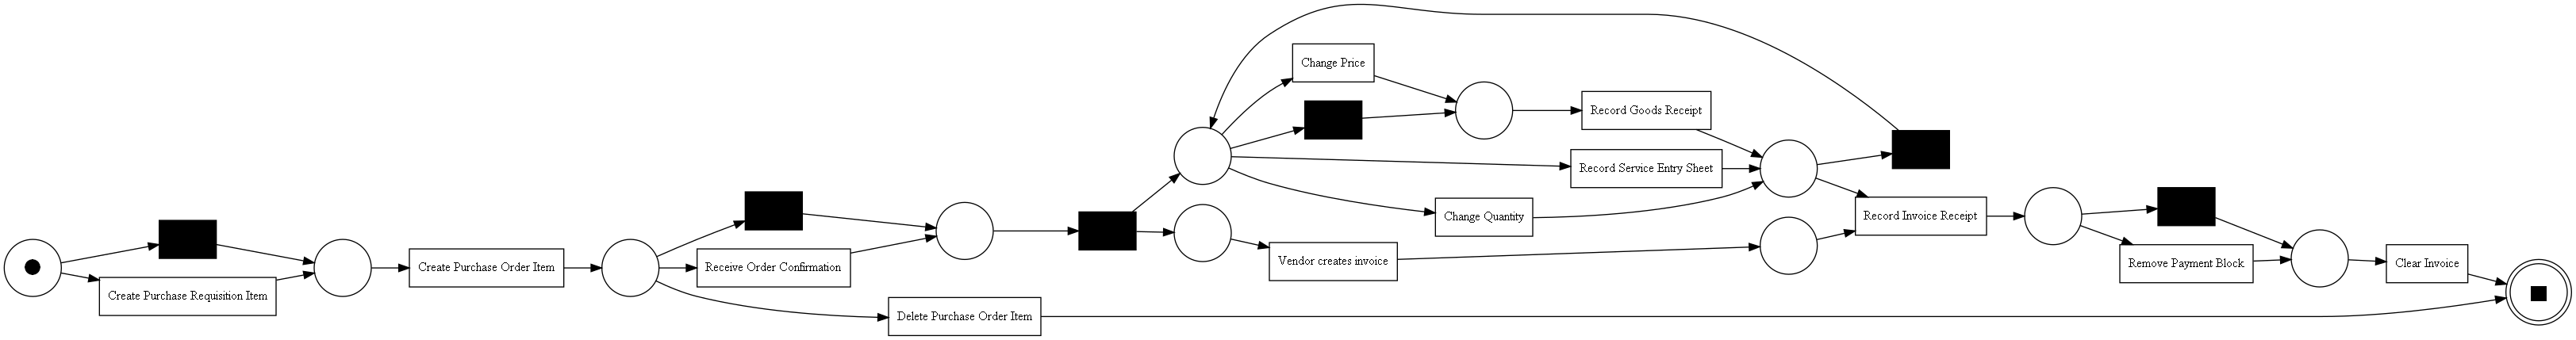

In [195]:
pm4py.view_petri_net(net, im, fm)

# Token-based replay

In [196]:
replayed_traces = pm4py.conformance_diagnostics_token_based_replay(log, net, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/4228 [00:00<?, ?it/s]

In [197]:
missing_tokens = 0
consumed_tokens = 0
remaining_tokens = 0
produced_tokens = 0

for trace in replayed_traces:
    missing_tokens += trace["missing_tokens"]
    consumed_tokens += trace["consumed_tokens"]
    remaining_tokens += trace["remaining_tokens"]
    produced_tokens += trace["produced_tokens"]

first_eq = 0.5 * (1 - float(missing_tokens)/float(consumed_tokens))
second_eq = 0.5 * (1 - float(remaining_tokens)/float(produced_tokens))

fitness = first_eq + second_eq

str((fitness, missing_tokens, consumed_tokens, remaining_tokens, produced_tokens))

'(0.9714673248875074, 21997, 696484, 17637, 692124)'

# Alignments

In [198]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

aligned_traces = alignments.apply_log(log, net, im, fm)

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
log_fitness = replay_fitness.evaluate(aligned_traces, variant=replay_fitness.Variants.ALIGNMENT_BASED)

print(log_fitness)

aligning log, completed variants ::   0%|          | 0/4228 [00:00<?, ?it/s]

{'percFitTraces': 51.33052298774865, 'averageFitness': 0.8614010687703352, 'percentage_of_fitting_traces': 51.33052298774865, 'average_trace_fitness': 0.8614010687703352, 'log_fitness': 0.889306501928989}


# Footprints

In [199]:
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
fp_trace_by_trace = footprints_discovery.apply(log, variant=footprints_discovery.Variants.TRACE_BY_TRACE)
fp_net = footprints_discovery.apply(net, im, fm)

In [200]:
from pm4py.visualization.footprints import visualizer as fp_visualizer

gviz = fp_visualizer.apply(fp_net, parameters={fp_visualizer.Variants.SINGLE.value.Parameters.FORMAT: "svg"})
fp_visualizer.view(gviz)

ValueError: Cannot embed the 'svg' image format

In [201]:
conf_fp = pm4py.conformance_diagnostics_footprints(fp_trace_by_trace, fp_net)

In [202]:
from pm4py.algo.conformance.footprints import algorithm as fp_conformance
from pm4py.algo.conformance.footprints.util import evaluation

conf_result = fp_conformance.apply(fp_log, fp_net, variant=fp_conformance.Variants.LOG_EXTENSIVE)

fitness = evaluation.fp_fitness(fp_log, fp_net, conf_result)
precision = evaluation.fp_precision(fp_log, fp_net)

In [203]:
(fitness, precision)

(0.9204824269929668, 0.8780487804878049)